# Optimization for Statistical Learning Part 2 - Experiment Notebook #

## Section 0 Environment Setup ##

In thise section, we are importing the libraries, datasets and associative python programme. In addition, setup the experiment environment.

### Section 0.1 Packages and Libraries ###

**Packages Installation**

In [1]:
#!pip install jupyter
#!pip install numpy
#!pip install torch torchvision 
#!pip install matplotlib
#!pip install pandas
#!pip install tensorflow
#!pip install torch
#!pip install torchvision
#!pip install torch_xla
#!pip install torch-neuron --extra-index-url=https://pip.repos.neuron.amazonaws.com/

**Importing Libraries**

In [2]:
import math
import statistics
import random
import timeit
from datetime import datetime
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

**Importing Python Programme**

Executing this, importing the global functions and classes directly.

### Section 0.1 Set up Experiment Environment ###

**Utilize GPU**

For local environments, please utilize the GPU to speed up the training time.

In [3]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

**Utililze TPU**

To shortern the training time, we highly recommend that experiments should be done in Google Colab. Enable the following code in the Google Colab platform.

In [ ]:
## Assume that you are on the Google Colab platform.
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()

def to_device(data, device):
    data.to(device)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

### Section 0.2 Datasets ##

#### Section 0.2.1 Importing Datasets from Packages ####
This will load the dataset automatically downloaded from the package. Remember the datasets will be stored in the folder "Datasets".

**MINST Dataset**

In [4]:
from torchvision.datasets import MNIST

# Download Dataset
MNIST_train_dataset = MNIST(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_test_dataset = MNIST(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000


**CIFAR-10 Dataset**

In [ ]:
from torchvision.datasets import CIFAR10

# Download Dataset
CIFAR10_train_dataset = CIFAR10(root='./Datasets', train=True, download=True, transform=transforms.ToTensor())
CIFAR10_test_dataset = CIFAR10(root='./Datasets', train=False, download=True, transform=transforms.ToTensor())

# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
train_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

#### Section 0.2.2 Importing Datasets from Downloaded Files ####
This will load the dataset downloaded in the local directories.

### Section 0.3 Optimizer and Loss functions ###
Here, we define some customized optimizer classes and loss functions.

## Section 1 Classes, Functions and Algorithms ##
We define all necessary functions for learning here.

In [5]:
############################
#     Helping Functions    #
############################
def convert_to_list(input_list):
    if not isinstance(input_list, list):
        input_list = [input_list]
    return input_list

# Graph Plotting Functions
def plot_cost_history(cost_history_list=[], save=True):
    cost_history_list = convert_to_list(cost_history_list)
    for i, cost_history in enumerate(cost_history_list):
        plt.plot(cost_history, label=f"Cost History {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Culminative Send Cost History")
    if len(cost_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_culminative_send_cost_history_{train_start_time}.png')
    plt.show()

def plot_time_history(time_history_list=[], save=True):
    time_history_list = convert_to_list(time_history_list)
    for i, time_history in enumerate(time_history_list):
        plt.plot(time_history, label=f"Time History {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Culminative Time Used")
    plt.title("Time History")
    if len(time_history_list) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_time_history_{train_start_time}.png')
    plt.show()

def plot_loss_history(train_loss_history_list=[], test_loss_history_list=[], save=True):
    train_loss_history_list = convert_to_list(train_loss_history_list)
    test_loss_history_list = convert_to_list(test_loss_history_list)
    for i, train_loss_history in enumerate(train_loss_history_list):
        plt.plot(train_loss_history, label=f"Train Loss History {i+1}")
    for i, test_loss_history in enumerate(test_loss_history_list):
        plt.plot(test_loss_history, label=f"Test Loss History {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss History")
    if (len(train_loss_history_list) + len(test_loss_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_loss_history_{train_start_time}.png')
    plt.show()

def plot_accuracy_history(train_accuracy_history_list=[], test_accuracy_history_list=[], save=True):
    train_accuracy_history_list = convert_to_list(train_accuracy_history_list)
    test_accuracy_history_list = convert_to_list(test_accuracy_history_list)
    for i, train_accuracy_history in enumerate(train_accuracy_history_list):
        plt.plot(train_accuracy_history, label=f"Train Accuracy History {i+1}")
    for i, test_accuracy_history in enumerate(test_accuracy_history_list):
        plt.plot(test_accuracy_history, label=f"Test Accuracy History {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy History")
    if (len(train_accuracy_history_list) + len(test_accuracy_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_accuracy_history_{train_start_time}.png')
    plt.show()

def plot_error_history(train_error_history_list=[], test_error_history_list=[], save=True):
    train_error_history_list = convert_to_list(train_error_history_list)
    test_error_history_list = convert_to_list(test_error_history_list)
    for i, train_error_history in enumerate(train_error_history_list):
        plt.plot(train_error_history, label=f"Train Error History {i+1}")
    for i, test_error_history in enumerate(test_error_history_list):
        plt.plot(test_error_history, label=f"Test Error History {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.title("Error History")
    if (len(train_error_history_list) + len(test_error_history_list)) > 1:
        plt.legend()
    if save:
        plt.savefig(f'{current_dataset_name}_error_history_{train_start_time}.png')
    plt.show()

# Accuracy and Error Rate Calculation
def get_accuracy(outputs, labels):
    with torch.no_grad():
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

def get_error(outputs, labels):
    with torch.no_grad():
        _, predictions = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(predictions != labels).item() / len(predictions))

############################
#   Neural Network Model   #
############################
class MNIST_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return torch.squeeze(x)

class CIFAR10_CNN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.activation_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            torch.nn.BatchNorm2d(64),

            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            torch.nn.BatchNorm2d(128),

            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            torch.nn.BatchNorm2d(256),

            torch.nn.Flatten(), 
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10))
        
    def forward(self, x):
        x = self.activation_stack(x)
        return torch.squeeze(x)

############################
#   CNN Iterate Algorithm  #
############################
def iterate_CNN_model(model, dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error, show_history=True):
    loss_history = []
    accuracy_history = []
    error_history = []
    time_history = []
    start_time = timeit.default_timer()
    for epoch in range(num_epochs):
        losses = []
        accuracies = []
        errors = []
        for batch in dataloader:
            images, labels = batch
            outputs = model(images)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss.detach()
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        time_used = timeit.default_timer() - start_time
        time_history.append(time_used)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
        loss_history.append(loss_average)
        accuracy_history.append(accuracy_average)
        error_history.append(error_average)
        if show_history:
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {loss_average:.16f}, Average Accuracy: {accuracy_average:.16f}, Average Error: {error_average:.16f}, Culminative Time Used: {time_used}')
    return loss_history, accuracy_history, error_history, time_history

def evaluate_CNN_model(model, dataloader, loss_func=torch.nn.functional.cross_entropy, accuracy_func=get_accuracy, error_func=get_error):
    losses = []
    accuracies = []
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            outputs = model(images)
            loss = loss_func(outputs, labels)
            accuracy = accuracy_func(outputs, labels)
            error = error_func(outputs, labels)
            losses.append(loss)
            accuracies.append(accuracy)
            errors.append(error)
        loss_average = torch.stack(losses).mean().item()
        accuracy_average = torch.stack(accuracies).mean().item()
        error_average = torch.stack(errors).mean().item()
    return loss_average, accuracy_average, error_average

############################
#      Client Devices      #
############################
# Define a custom class for each client so they can update separately
class ClientDevice:
    def __init__(self, client_id, model, optimizer, dataset, batch_size, iterate_func):
        self.id = client_id
        self.model = model
        self.optimizer = optimizer
        self.dataset = dataset
        self.dataloader = DeviceDataLoader(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True), device)
        self.iterate_func = iterate_func

    def load_weights(self, weights):
        self.model.load_state_dict(weights)

    def get_local_weights(self):
        return self.model.state_dict()
    
    def get_client_id(self):
        return self.id
    
    def get_dataset_size(self):
        return len(self.dataset)

    def save_local_history(self, num_epochs, loss_history, accuracy_history, error_history, time_history, value=train_start_time):
        filename = "{}_client_{}_with_local_epochs_{}_local_loss_accuracy_error_history_{}.npy".format(current_dataset_name, self.id, num_epochs, value)
        with open(filename, 'wb') as f:
            np.savez(f, loss_history=loss_history, accuracy_history=accuracy_history, error_history=error_history, time_history=time_history)

    def train(self, num_epochs, show_history=False):
        if show_history:
            print(f"!-- Client {self.id} start iterations. ---!")
        loss_history, accuracy_history, error_history, time_history = self.iterate_func(self.model, self.dataloader, num_epochs, self.optimizer)
        if show_history:
            plot_time_history(time_history)
            plot_loss_history(loss_history)
            plot_accuracy_history(accuracy_history)
            plot_error_history(error_history)
            print(f"!-- Client {self.id} finish iterations. ---!")
        return self.model.state_dict()

# Distribute the training datasets to clients, remember it returns an array of datasets
def split_datasets_for_clients_random(dataset, num_clients=1):
    total_sample_size = len(dataset)
    samples_per_clients = total_sample_size // num_clients
    client_datasets = random_split(dataset, [min(i + samples_per_clients, total_sample_size) - i for i in range(0, total_sample_size, samples_per_clients)])
    return client_datasets

# Be careful where the label placed and remember to modify the sample[1] if necessary
# Not correct
def split_datasets_by_label(dataset, num_labels=10):
    sorted_by_value = [0] * num_labels
    for i in range(num_labels):
        sorted_by_value[i] =(dataset.data[np.where(np.array(dataset.targets) == i)])
        np.random.shuffle(sorted_by_value[i])
    return sorted_by_value

def split_datasets_for_clients_label(dataset, num_clients=1, num_labels=10):
    total_sample_size = len(dataset)
    samples_per_client = total_sample_size // num_clients
    remaining_samples = total_sample_size % num_clients

    # Determine labels for each client
    labels_per_client = num_labels // num_clients
    client_labels = [list(range(i * labels_per_client, (i + 1) * labels_per_client + 1)) for i in range(num_clients)]
    remaining_labels = list(range(num_clients * labels_per_client, num_labels))
    for client_id in range(num_clients):
        client_labels[client_id].extend(remaining_labels[:client_id])

    # Filter samples for each client
    client_datasets = []
    for client_id in range(num_clients):
        labels = client_labels[client_id]
        filtered_dataset = [sample for sample in dataset if dataset.targets in labels]

        # Adjust the length of the dataset for the last client to include remaining samples
        client_samples = samples_per_client + (remaining_samples if client_id == num_clients - 1 else 0)

        client_dataset = random_split(filtered_dataset, [client_samples] * num_clients)
        client_datasets.append(client_dataset)

    return client_datasets

# Establish client devices
def establish_client_devices(num_clients, model_list, optimizer_list, dataset_list, batch_size_list, iterate_func_list):
    client_device = [None] * num_clients
    for client_id in range(num_clients):
        client_device[client_id] = ClientDevice(client_id, model_list[client_id], optimizer_list[client_id], dataset_list[client_id], batch_size_list[client_id], iterate_func_list[client_id])
    return client_device

############################
#    Training Algorithm    #
############################
def train_CNN_model(model, train_dataloader, test_dataloader, num_epochs, optimizer, loss_func=torch.nn.functional.cross_entropy, show_history=True, save_result=True):
    train_loss_history, train_accuracy_history, train_error_history, time_history = iterate_CNN_model(model, train_dataloader, num_epochs, optimizer, loss_func)

    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []
    if test_dataloader is not None:
        for epoch in range(num_epochs):
            test_loss, test_accuracy, test_error = evaluate_CNN_model(model, test_dataloader)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.apeend(test_error)

    # Print learned parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_train_CNN_model_with_num_epochs_{}_{}".format(current_dataset_name, num_epochs, train_start_time)
        with open(filename, 'wb') as f:
            np.savez(f, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history)

    # Graph
    if show_history:
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def federated_averaging(client_weights_total):
    total_clients = len(client_weights_total)
    aggregate_weights = {}

    # Initialize aggregate_weights with the first client's weights
    for layer_name, layer_weights in client_weights_total[0].items():
        aggregate_weights[layer_name] = layer_weights / total_clients

    # Aggregate weights from the remaining clients
    for client_weights in client_weights_total[1:]:
        for layer_name, layer_weights in client_weights.items():
            aggregate_weights[layer_name] += layer_weights / total_clients

    return aggregate_weights

def iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, global_epochs, local_epochs, aggregate_func=federated_averaging,show_history=True):
    cost_history = []
    time_history = []
    start_time = timeit.default_timer()
    send_cost = 0.00

    train_loss_history = []
    train_accuracy_history = []
    train_error_history = []
    test_loss_history = []
    test_accuracy_history = []
    test_error_history = []

    for epoch in range(global_epochs):
        global_weights = global_model.state_dict()
        client_weights_total = []
        for client in client_list:
            client.load_weights(global_weights)
            client_weights = client.train(num_epochs=local_epochs)
            client_weights_total.append(client_weights)
            send_cost += sum(value.numel() for value in client_weights.values())
        global_weights.update(aggregate_func(client_weights_total))
        global_model.load_state_dict(global_weights)

        # Record
        time_used = timeit.default_timer() - start_time
        cost_history.append(send_cost)
        time_history.append(time_used)

        train_loss, train_accuracy, train_error = evaluate_CNN_model(global_model, train_dataloader)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        train_error_history.append(train_error)

        if test_dataloader is not None:
            test_loss, test_accuracy, test_error = evaluate_CNN_model(global_model, test_dataloader)
            test_loss_history.append(test_loss)
            test_accuracy_history.append(test_accuracy)
            test_error_history.append(test_error)

        if show_history:
            print(f'Epoch [{epoch+1}/{global_epochs}], Culminative Send Cost: {send_cost}, Culminative Time Used: {time_used}')
            print(f'Train Loss: {train_loss:.16f}, Train Accuracy: {train_accuracy:.16f}, Train Error: {train_error:.16f}')
            if test_dataloader is not None:
                print(f'Test Loss: {test_loss:.16f}, Test Accuracy: {test_accuracy:.16f}, Test Error: {test_error:.16f}')

    return cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def train_federated_learning_model(global_model, train_dataloader, test_dataloader, global_epochs, local_epochs, client_list, batch_size, aggregate_func=federated_averaging, show_history=True, save_result=True):
    cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = iterate_federated_learning_model(global_model, train_dataloader, test_dataloader, client_list, global_epochs, local_epochs, aggregate_func)

    # Print learned parameters
    for name, param in global_model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.data}')
    
    # Save Results
    if save_result:
        filename = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}".format(current_dataset_name, "FedAvg", global_epochs, local_epochs, len(client_list), batch_size, train_start_time)
        with open(filename, 'wb') as f:
            np.savez(f, cost_history=cost_history, time_history=time_history, train_loss_history=train_loss_history, train_accuracy_history=train_accuracy_history, train_error_history=train_error_history, test_loss_history=test_loss_history, test_accuracy_history=test_accuracy_history, test_error_history=test_error_history)
        torch.save(global_model.state_dict(), filename + "_model_state_dict.pth")

    # Graph
    if show_history:
        plot_cost_history([cost_history])
        plot_time_history([time_history])
        plot_loss_history([train_loss_history], [test_loss_history])
        plot_accuracy_history([train_accuracy_history], [test_accuracy_history])
        plot_error_history([train_error_history], [test_error_history])
    
    return cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history

def expirement_federated_learning_model(train_dataset, test_dataset, modelClass, optimizerClass, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, aggregate_func_list, compare_id = 0, show_history=True, save_result=True):
    global_epochs_list = convert_to_list(global_epochs_list)
    local_epochs_list = convert_to_list(local_epochs_list)
    num_clients_list = convert_to_list(num_clients_list)
    learning_rate_list = convert_to_list(learning_rate_list)
    batch_size_list = convert_to_list(batch_size_list)
    aggregate_func_list = convert_to_list(aggregate_func_list)
    global_epochs_list_size = len(global_epochs_list)
    local_epochs_list_size = len(local_epochs_list)
    num_clients_list_size = len(num_clients_list)
    learning_rate_list_size = len(learning_rate_list)
    batch_size_list_size = len(batch_size_list)
    aggregate_func_list_size = len(batch_size_list)

    cost_history_total = []
    time_history_total = []
    train_loss_history_total = []
    train_accuracy_history_total = []
    train_error_history_total = []
    test_loss_history_total = []
    test_accuracy_history_total = []
    test_error_history_total = []

    if compare_id == 2:
        iteration_list = local_epochs_list
    elif compare_id == 3:
        iteration_list = num_clients_list
    elif compare_id == 4:
        iteration_list = learning_rate_list
    elif compare_id == 5:
        iteration_list = batch_size_list
    elif compare_id == 6:
        iteration_list = aggregate_func_list
    else:
        iteration_list = global_epochs_list
    
    for n in range(len(iteration_list)):
        if compare_id == 2:
            print(f'=== The training for local_epochs is {local_epochs_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[n]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            aggregate_func = aggregate_func_list[0]
        elif compare_id == 3:
            print(f'=== The training for num_clients is {num_clients_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[n]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            aggregate_func = aggregate_func_list[0]
        elif compare_id == 4:
            print(f'=== The training for learning_rate_list is {learning_rate_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[n]
            batch_size = batch_size_list[0]
            aggregate_func = aggregate_func_list[0]
        elif compare_id == 5:
            print(f'=== The training for batch_size_list is {batch_size_list[n]} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[n]
            aggregate_func = aggregate_func_list[0]
        elif compare_id == 6:
            print(f'=== The training for aggregate function is {aggregate_func_list[n].__name__} ===')
            global_epochs = global_epochs_list[0]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
            aggregate_func = aggregate_func_list[n]
        else:
            print(f'=== The training for global_epochs is {global_epochs_list[n]} ===')
            global_epochs = global_epochs_list[n]
            local_epochs = local_epochs_list[0]
            num_clients = num_clients_list[0]
            learning_rate = learning_rate_list[0]
            batch_size = batch_size_list[0]
        
        global_model = to_device(modelClass(), device)
        print(global_model)

        train_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True), device)
        test_dataloader = DeviceDataLoader(torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False), device)

        client_model_list = [to_device(modelClass(), device)] * num_clients
        client_optimizer_list = [optimizerClass(model.parameters(), learning_rate) for model in client_model_list]
        client_dataset_list = split_datasets_for_clients_random(train_dataset, num_clients)
        client_batch_size_list = [batch_size] * num_clients
        client_itera_func_list = [itera_func] * num_clients
        client_list = establish_client_devices(num_clients, client_model_list, client_optimizer_list, client_dataset_list, client_batch_size_list, client_itera_func_list)

        cost_history, time_history, train_loss_history, train_accuracy_history, train_error_history, test_loss_history, test_accuracy_history, test_error_history = train_federated_learning_model(global_model, train_dataloader, test_dataloader, global_epochs, local_epochs, client_list, batch_size, aggregate_func)

        cost_history_total.append(cost_history)
        time_history_total.append(time_history)
        train_loss_history_total.append(train_loss_history)
        train_accuracy_history_total.append(train_accuracy_history)
        train_error_history_total.append(train_error_history)
        test_loss_history_total.append(test_loss_history)
        test_accuracy_history_total.append(test_accuracy_history)
        test_error_history_total.append(test_error_history)
    
    print(f'=== The Experiment Result ===')
    print(f'Name of current dataset: {current_dataset_name}')
    plot_cost_history(cost_history_total)
    plot_time_history(time_history_total)
    plot_loss_history(train_loss_history_total, test_loss_history_total)
    plot_accuracy_history(train_accuracy_history_total, test_accuracy_history_total)
    plot_error_history(train_error_history_total, test_error_history_total)

## Section 2 Experiment ##

### Section 2.1 Choose Dataset ###

In this section, execute a cell only to choose a dataset you want do experiment with it.

**MNIST Dataset**

In [6]:
# Load Dataset
train_dataset = MNIST_train_dataset
test_dataset = MNIST_test_dataset

# Show Dataset Status
current_dataset_name = "MNIST"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.005
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) * (1 - split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.05
#test_dataset, _ = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) * (1 - split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 784
model_type_preset = MNIST_CNN_Model
optimizer_type_preset = torch.optim.SGD

The current dataset is MNIST.
Number of samples in the train dataset: 60000
Number of samples in the test dataset: 10000
Number of samples in the train dataset after random split: 60000
Number of samples in the test dataset after random split: 10000


**CIFAR10 Dataset**

In [ ]:
# Load Dataset
train_dataset = CIFAR10_train_dataset
test_dataset = CIFAR10_test_dataset

# Show Dataset Status
current_dataset_name = "CIFAR10"
print(f'The current dataset is {current_dataset_name}.')
print(f'Number of samples in the train dataset: {len(train_dataset)}')
print(f'Number of samples in the test dataset: {len(test_dataset)}')

# Validation Dataset
#split_ratio = 0.002
#train_dataset, validation_dataset = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) * (1 - split_ratio))])
print(f'Number of samples in the train dataset after random split: {len(train_dataset)}')
#split_ratio = 0.05
#test_dataset, _ = random_split(train_dataset, [int(len(train_dataset) * split_ratio), int(len(train_dataset) * (1 - split_ratio))])
print(f'Number of samples in the test dataset after random split: {len(test_dataset)}')

# Define variables associate with the dataset
learning_rate_preset = 0.5
batch_size_preset = 100
num_features_preset = 1
num_classes_preset = 10
input_dim = 1024
model_type_preset = CIFAR10_CNN_Model
optimizer_type_preset = torch.optim.SGD

### Section 2.2 Federated Learning Experiments ###

Note that, compare_id represents:

1: compare global epochs

2: compare local epochs

3: compare number of clients

4: compare learning rate

5: compare batch size

6: compare the aggregate weight algorithms

Others: compare global epochs

**Experiment: Compare Local Update Epochs**

In [ ]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_CNN_model

global_epochs_list = 100
local_epochs_list = [2, 3, 4, 5]
num_clients_list = 10
learning_rate_list = 0.02
batch_size_list = 128
aggregate_func_list = federated_averaging

compare_id = 2

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

expirement_federated_learning_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, aggregate_func_list, compare_id)

**Experiment: Compare Number of Clients**

The current dataset is MNIST.
The current train start time is 2023-12-06 19.00.14.
=== The training for num_clients is 1 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/3], Average Loss: 0.7620388865470886, Average Accuracy: 0.7935045361518860, Average Error: 0.2064954340457916, Culminative Time Used: 21.988783799984958
Epoch [2/3], Average Loss: 0.2037717849016190, Average Accuracy: 0.9401429891586304, Average Error: 0.0598569661378860, Culminative Time Used: 45.08791250002105
Epoch [3/3], Average Loss: 0.1406664699316025, Average Accuracy: 0.9591884613037109, Average Error: 0.04081156

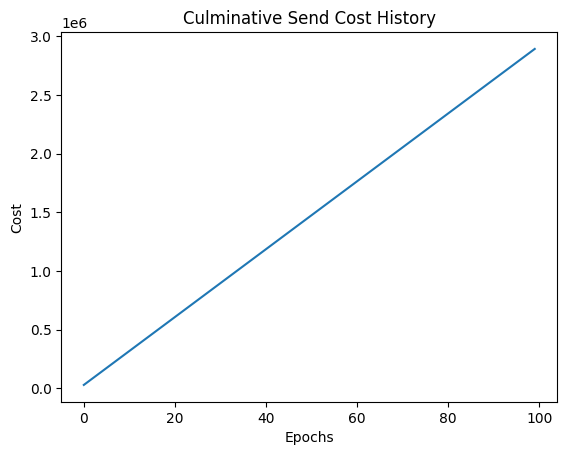

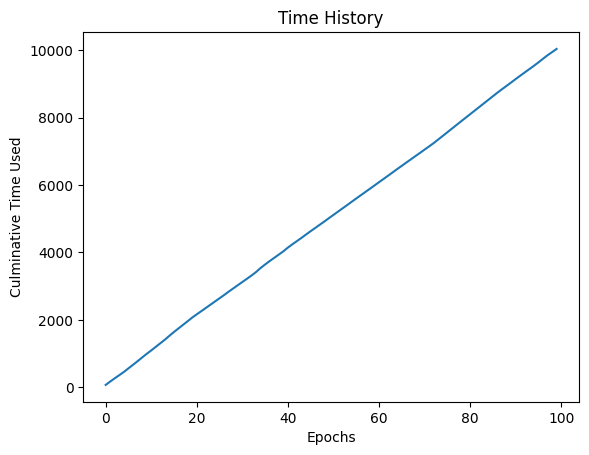

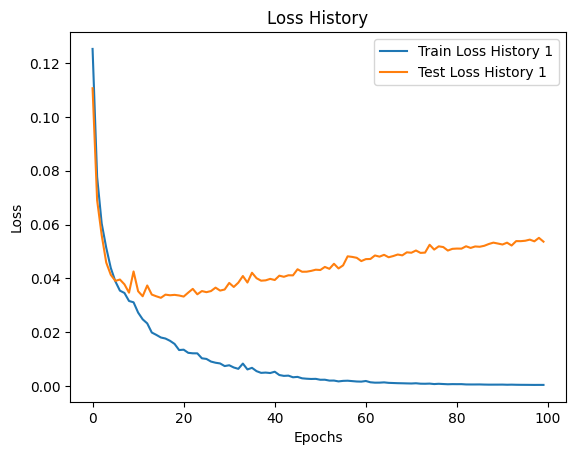

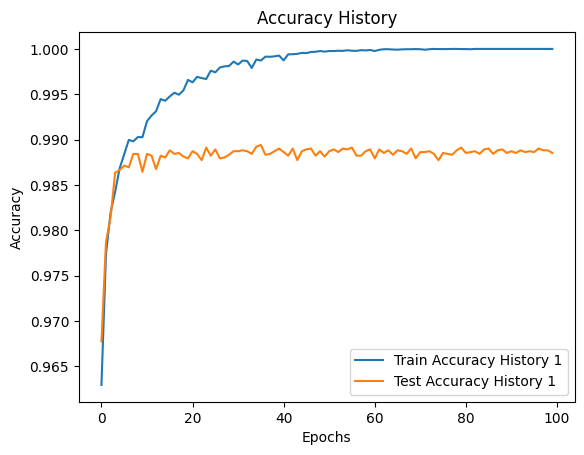

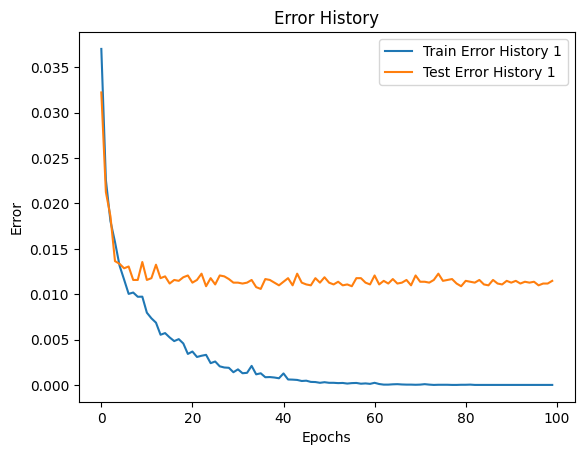

=== The training for num_clients is 5 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/3], Average Loss: 2.1161406040191650, Average Accuracy: 0.3783521354198456, Average Error: 0.6216478347778320, Culminative Time Used: 5.002957699995022
Epoch [2/3], Average Loss: 0.8487584590911865, Average Accuracy: 0.7723293900489807, Average Error: 0.2276706695556641, Culminative Time Used: 9.938161899975967
Epoch [3/3], Average Loss: 0.4520123302936554, Average Accuracy: 0.8622838854789734, Average Error: 0.1377160847187042, Culminative Time Used: 15.014722099993378
Epoch [1/3], Average Loss: 2.111

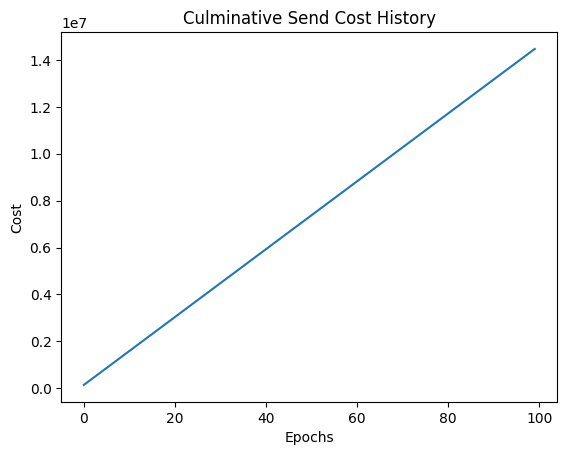

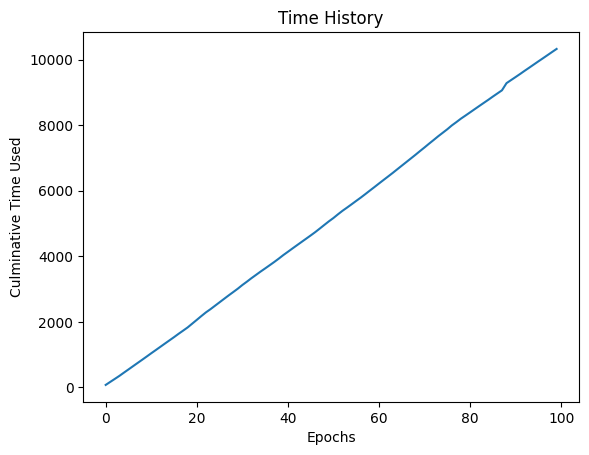

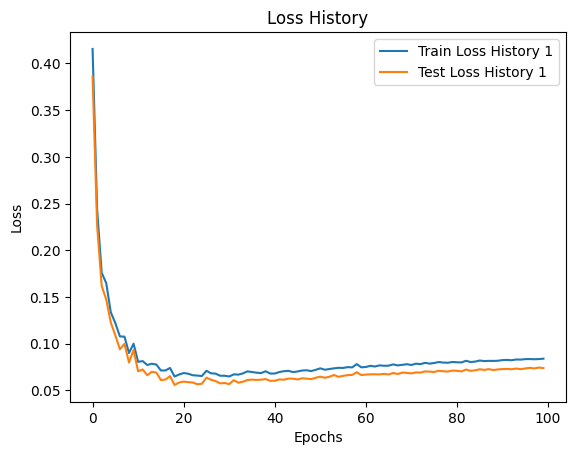

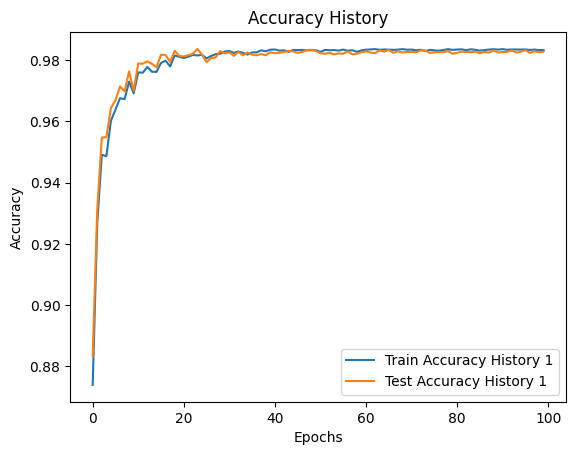

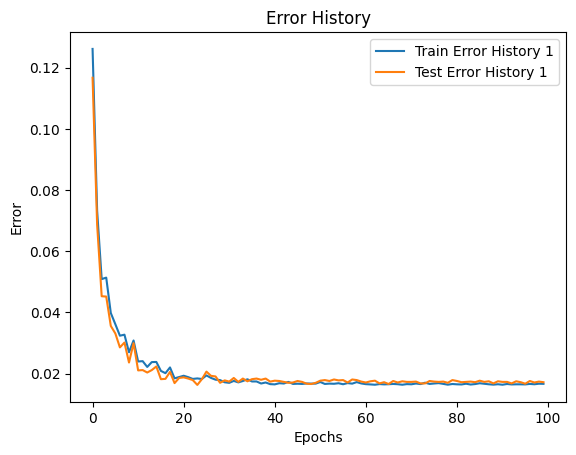

=== The training for num_clients is 20 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/3], Average Loss: 2.2765233516693115, Average Accuracy: 0.2188429981470108, Average Error: 0.7811570167541504, Culminative Time Used: 1.4305061000050046
Epoch [2/3], Average Loss: 2.1890556812286377, Average Accuracy: 0.3474237024784088, Average Error: 0.6525762677192688, Culminative Time Used: 2.7647864000173286
Epoch [3/3], Average Loss: 1.9543594121932983, Average Accuracy: 0.6022600531578064, Average Error: 0.3977399766445160, Culminative Time Used: 4.130957800021861
Epoch [1/3], Average Loss: 2.2

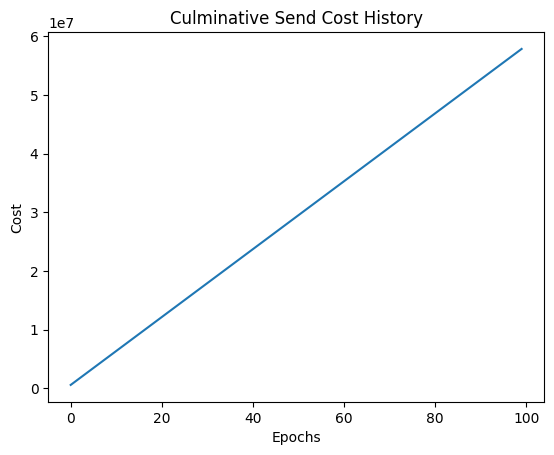

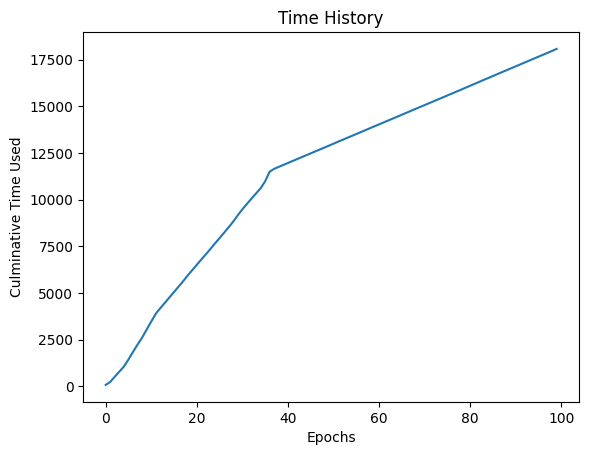

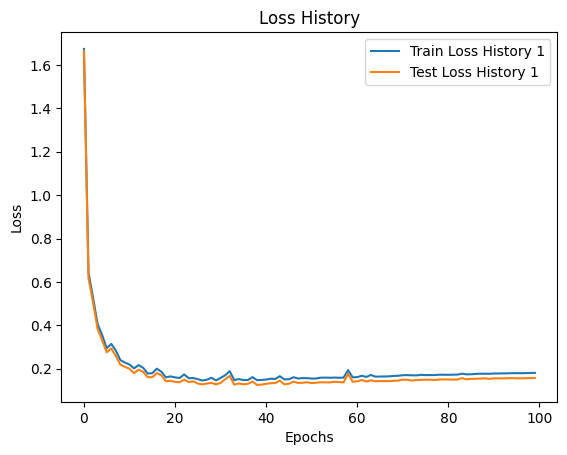

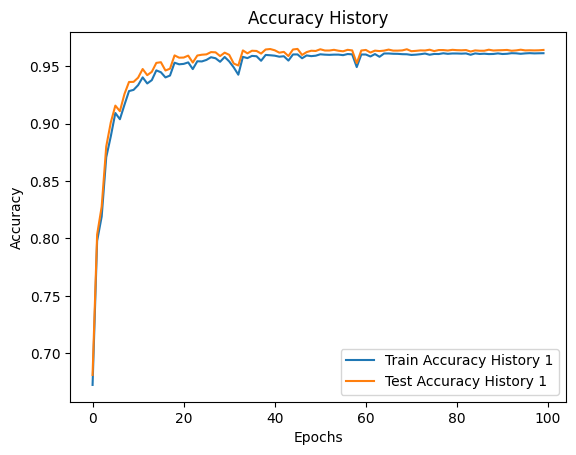

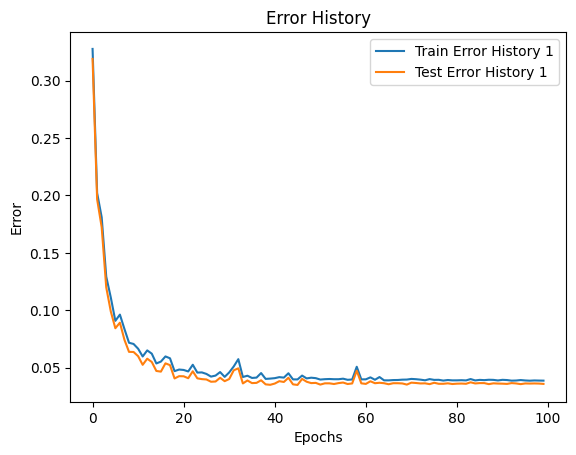

=== The Experiment Result ===
Name of current dataset: MNIST


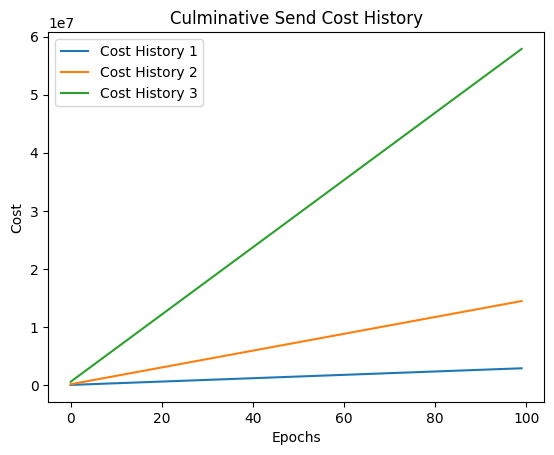

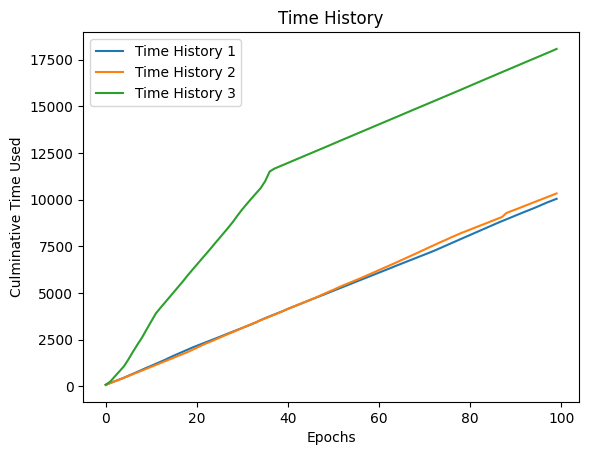

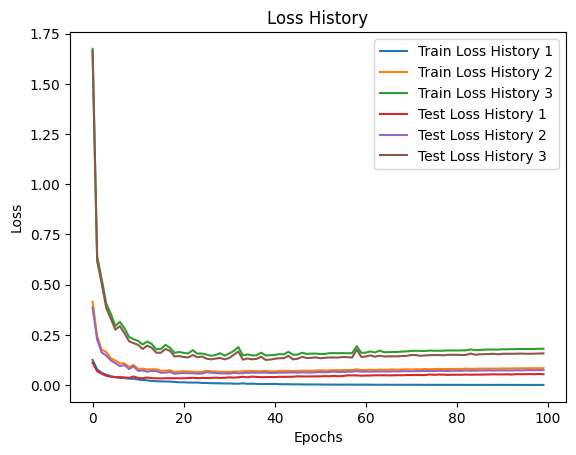

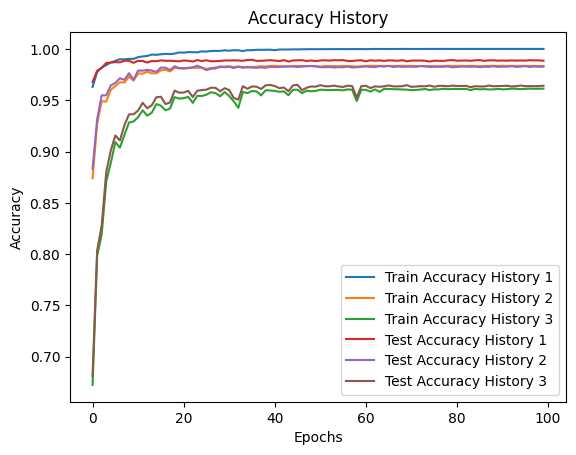

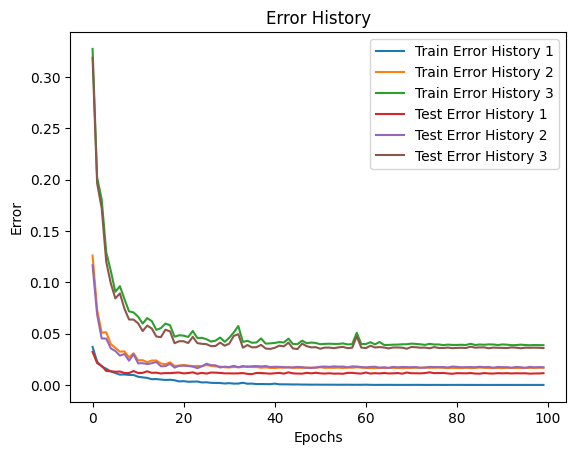

In [7]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_CNN_model

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = [1, 5, 20]
learning_rate_list = 0.02
batch_size_list = 128
aggregate_func_list = federated_averaging

compare_id = 3

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

expirement_federated_learning_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, aggregate_func_list, compare_id)

**Experiment: Compare Learning Rate**

The current dataset is MNIST.
The current train start time is 2023-12-07 11.39.56.
=== The training for learning_rate_list is 0.02 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[ 0.1558,  0.0526, -0.1440, -0.1564,  0.1432],
          [-0.0222, -0.1558, -0.1326, -0.0777,  0.1092],
          [-0.1203,  0.0749, -0.0128, -0.0378,  0.1924],
          [ 0.0518,  0.0330, -0.0187, -0.1376, -0.1554],
          [-0.0052,  0.1284, -0.1984,  0.1112,  0.1032]]],


        [[[-0.0742,  0.1864, -0.1946,  0.0146, -0.0606],
          [ 0.0168,  0.1259, -0.0992, -0.1183, 

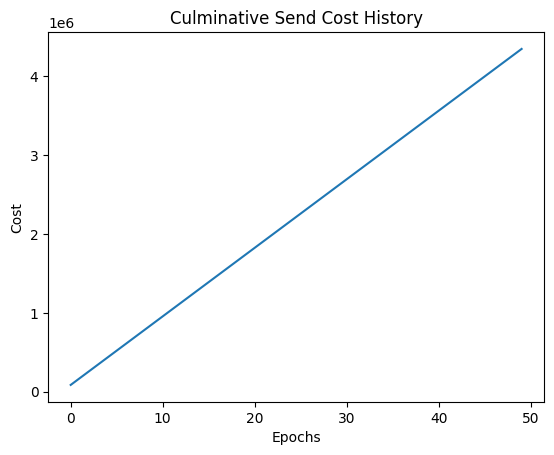

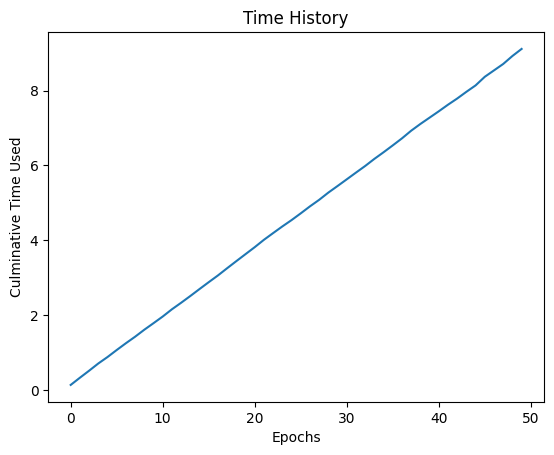

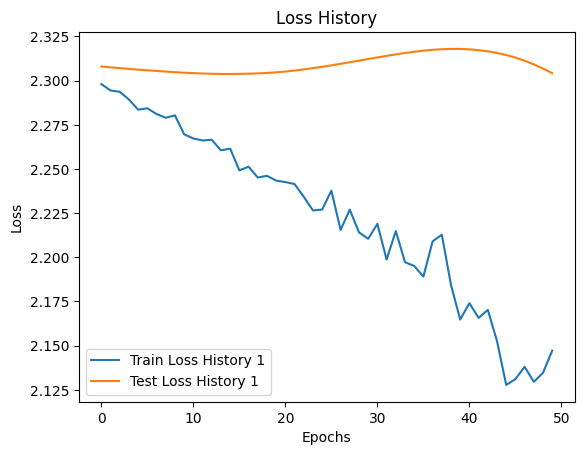

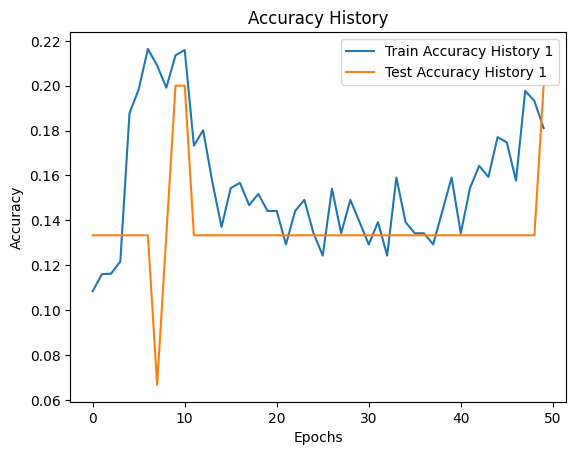

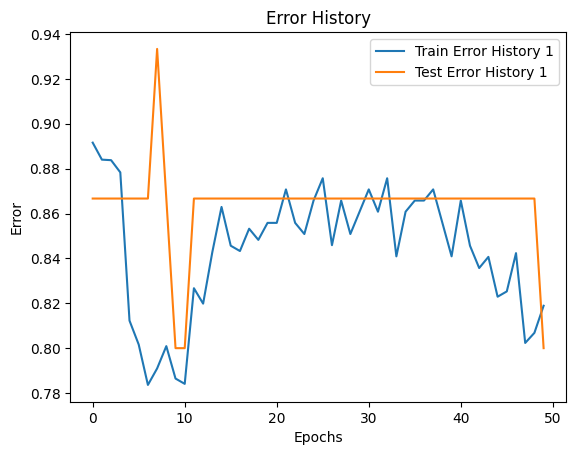

=== The training for learning_rate_list is 0.02 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
OrderedDict([('conv1.weight', tensor([[[[ 1.6658e-01, -1.8855e-01, -1.6778e-02,  1.7866e-01,  1.6850e-01],
          [ 1.6393e-01, -1.5537e-01, -1.6207e-01, -1.2080e-01,  3.1027e-02],
          [ 1.2964e-01,  1.6071e-02,  6.8943e-02, -1.7850e-01,  7.2670e-02],
          [ 1.6233e-02,  2.4471e-02,  1.2255e-02, -3.5965e-02,  6.1194e-02],
          [ 4.5521e-03, -7.6008e-02,  1.6286e-01,  1.1601e-02,  1.3695e-01]]],


        [[[ 1.4719e-01,  7.3208e-02, -1.1747e-01,  1.4199e-01,  1.2337e-01],
          

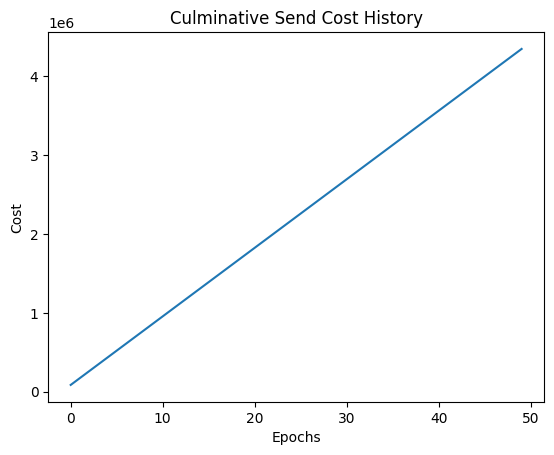

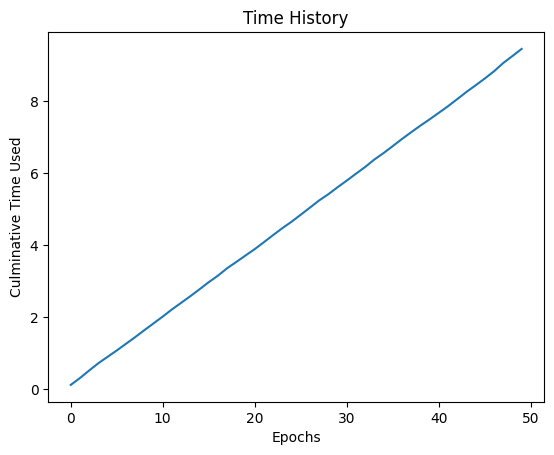

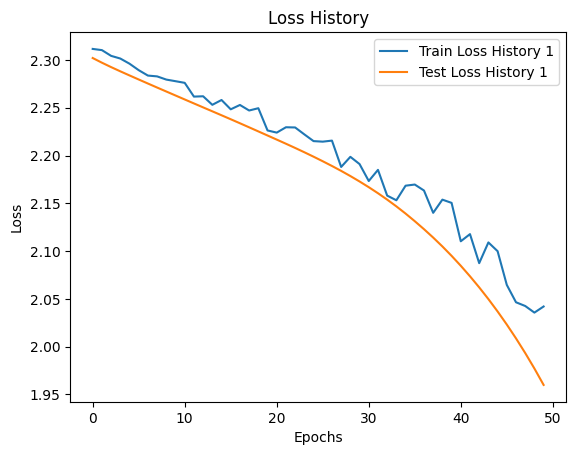

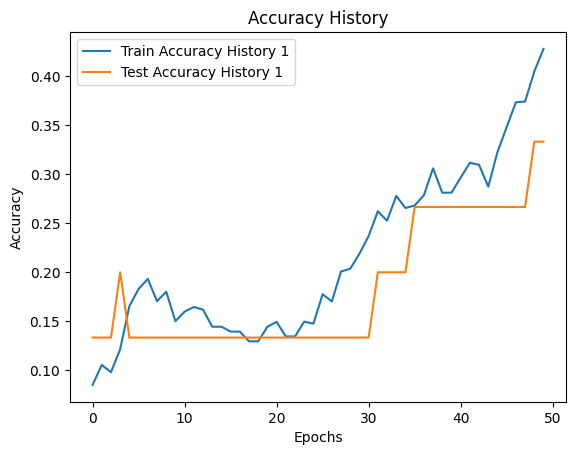

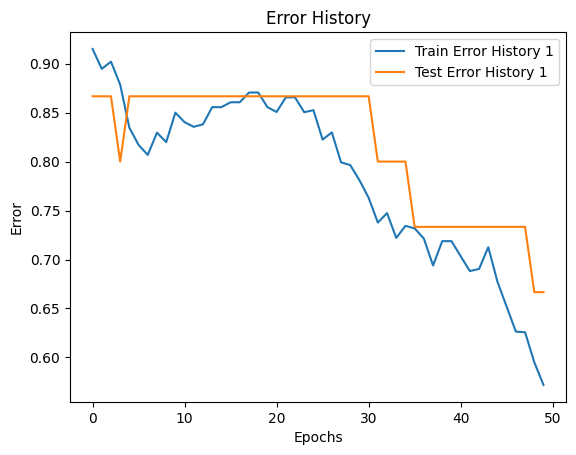

=== The Experiment Result ===
Name of current dataset: MNIST


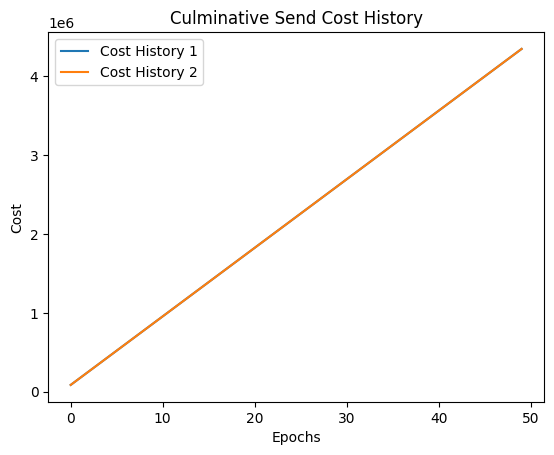

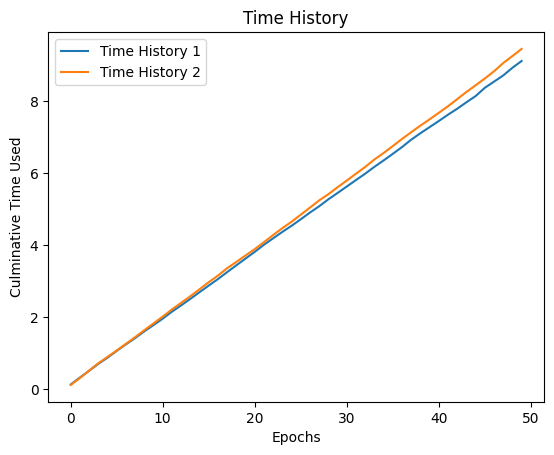

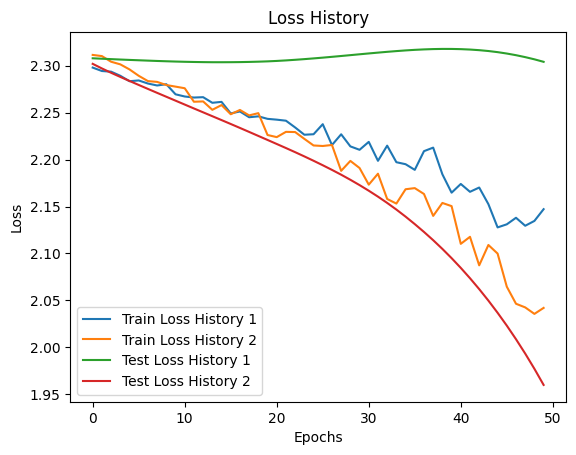

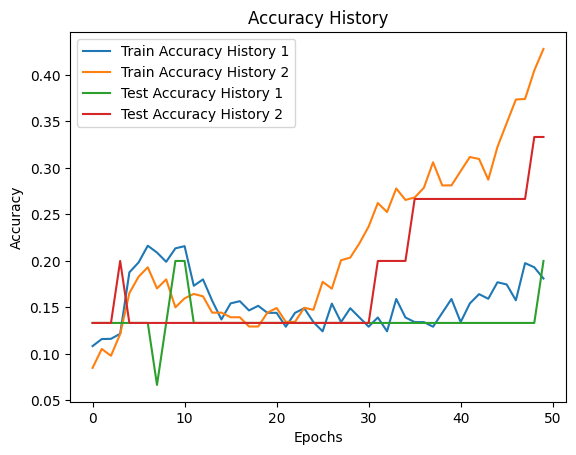

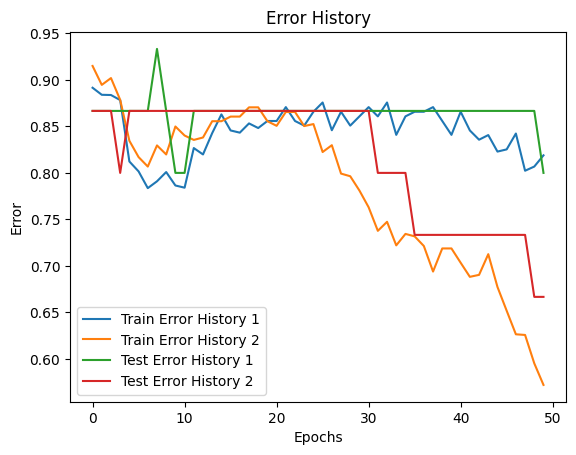

In [21]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_CNN_model

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = 10
learning_rate_list = [0.01, 0.1, 1.0]
batch_size_list = 128
aggregate_func_list = federated_averaging

compare_id = 4

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

expirement_federated_learning_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, aggregate_func_list, compare_id)

**Experiment: Compare Batch Size**

In [7]:
modelType = model_type_preset
optimizerType = optimizer_type_preset
itera_func = iterate_CNN_model

global_epochs_list = 100
local_epochs_list = 3
num_clients_list = 10
learning_rate_list = 0.02
batch_size_list = [10, 128, 1000]
aggregate_func_list = federated_averaging

compare_id = 5

print(f'The current dataset is {current_dataset_name}.')
train_start_time = datetime.now().strftime("%Y-%m-%d %H.%M.%S")
print(f'The current train start time is {train_start_time}.')

expirement_federated_learning_model(train_dataset, test_dataset, modelType, optimizerType, itera_func, global_epochs_list, local_epochs_list, num_clients_list, learning_rate_list, batch_size_list, aggregate_func_list, compare_id)

The current dataset is MNIST.
The current train start time is 2023-12-07 15.12.53.
=== The training for batch_size_list is 10 ===
MNIST_CNN_Model(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/3], Average Loss: 0.6773959398269653, Average Accuracy: 0.7858333587646484, Average Error: 0.2141666412353516, Culminative Time Used: 3.6816578999996636
Epoch [2/3], Average Loss: 0.1992838233709335, Average Accuracy: 0.9398332834243774, Average Error: 0.0601666718721390, Culminative Time Used: 7.743093499999759
Epoch [3/3], Average Loss: 0.1328319311141968, Average Accuracy: 0.9598332643508911, Average Error: 0.040

## Section 3 Analysis ##

#### Section 3.1 Loading Data ####

**Clear and Initialize Data**

In [7]:
data_cost_history_total = []
data_time_history_total = []
data_train_loss_history_total = []
data_train_accuracy_history_total = []
data_train_error_history_total = []
data_test_loss_history_total = []
data_test_accuracy_history_total = []
data_test_error_history_total = []

**Loading Data Manually**

Result has been loaded from the file:  MNIST_FedAvg_with_global_epochs_100_local_epochs_3_num_clients_10_batch_size_1000_2023-12-07 15.12.53.npy
=======Content of the File=======
['cost_history', 'time_history', 'train_loss_history', 'train_accuracy_history', 'train_error_history', 'test_loss_history', 'test_accuracy_history', 'test_error_history']
=======VISUALIZATION RESULT=======


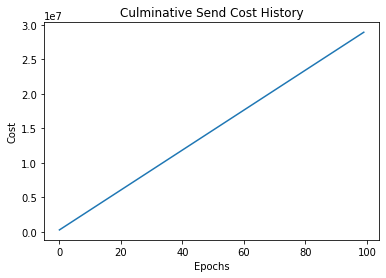

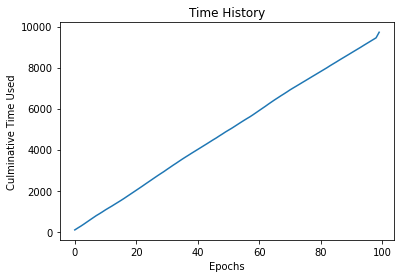

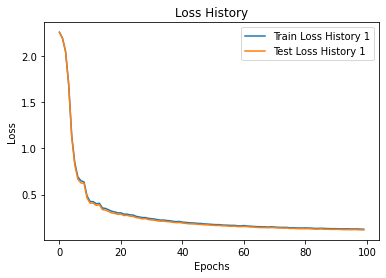

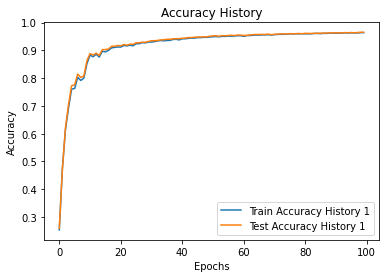

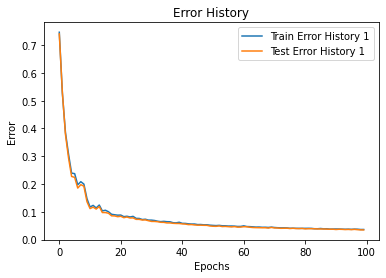

=======STATUS RESULT=======
Cost History:  [  289380.   578760.   868140.  1157520.  1446900.  1736280.  2025660.
  2315040.  2604420.  2893800.  3183180.  3472560.  3761940.  4051320.
  4340700.  4630080.  4919460.  5208840.  5498220.  5787600.  6076980.
  6366360.  6655740.  6945120.  7234500.  7523880.  7813260.  8102640.
  8392020.  8681400.  8970780.  9260160.  9549540.  9838920. 10128300.
 10417680. 10707060. 10996440. 11285820. 11575200. 11864580. 12153960.
 12443340. 12732720. 13022100. 13311480. 13600860. 13890240. 14179620.
 14469000. 14758380. 15047760. 15337140. 15626520. 15915900. 16205280.
 16494660. 16784040. 17073420. 17362800. 17652180. 17941560. 18230940.
 18520320. 18809700. 19099080. 19388460. 19677840. 19967220. 20256600.
 20545980. 20835360. 21124740. 21414120. 21703500. 21992880. 22282260.
 22571640. 22861020. 23150400. 23439780. 23729160. 24018540. 24307920.
 24597300. 24886680. 25176060. 25465440. 25754820. 26044200. 26333580.
 26622960. 26912340. 27201720. 274

In [10]:
# Change these variables manually here!!
load_dataset_name = "MNIST"
load_aggreagte_func = "FedAvg"
load_global_epochs = 100
load_local_epochs = 3
load_num_clients = 10
load_batch_size = 1000
load_train_start_time = "2023-12-07 15.12.53"
data_append_load = True

# Load the file
filename_load = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}.npy".format(load_dataset_name, load_aggreagte_func, load_global_epochs, load_local_epochs, load_num_clients, load_batch_size, load_train_start_time)
load_result = np.load(filename_load)
print('Result has been loaded from the file: ', filename_load)

# Load the attributes from the file
data_cost_history = load_result['cost_history']
data_time_history = load_result['time_history']
data_train_loss_history = load_result['train_loss_history']
data_train_accuracy_history = load_result['train_accuracy_history']
data_train_error_history = load_result['train_error_history']
data_test_loss_history = load_result['test_loss_history']
data_test_accuracy_history = load_result['test_accuracy_history']
data_test_error_history = load_result['test_error_history']

print("=======Content of the File=======")
print(load_result.files)

print("=======VISUALIZATION RESULT=======")
plot_cost_history([data_cost_history], save=False)
plot_time_history([data_time_history], save=False)
plot_loss_history([data_train_loss_history], [data_test_loss_history], save=False)
plot_accuracy_history([data_train_accuracy_history], [data_test_accuracy_history], save=False)
plot_error_history([data_train_error_history], [data_test_error_history], save=False)

print("=======STATUS RESULT=======")
print("Cost History: ", data_cost_history)
print("Time History: ", data_time_history)

print("=======TRAIN RESULT=======")
print("Train Loss History: ", data_train_loss_history)
print("Train Accuracy History: ", data_train_accuracy_history)
print("Train Error History: ", data_train_error_history)

print("=======TEST RESULT=======")
print("Test Loss History: ", data_test_loss_history)
print("Test Accuracy History: ", data_test_accuracy_history)
print("Test Error History: ", data_test_error_history)

# Append the data
if data_append_load:
    data_cost_history_total.append(data_cost_history)
    data_time_history_total.append(data_time_history)
    data_train_loss_history_total.append(data_train_loss_history)
    data_train_accuracy_history_total.append(data_train_accuracy_history)
    data_train_error_history_total.append(data_train_error_history)
    data_test_loss_history_total.append(data_test_loss_history)
    data_test_accuracy_history_total.append(data_test_accuracy_history)
    data_test_error_history_total.append(data_test_error_history)

**Loading Data Using Loop**

In [ ]:
# Change these variables manually here!!
# load_loop_max correspond to number of files you want to load
load_dataset_name_list = ["MNIST"]
load_aggreagte_func_list = ["FedAvg"]
load_global_epochs_list = [2]
load_local_epochs_list = [1]
load_num_clients_list = [2]
load_batch_size_list = [128]
load_train_start_time_list = ["2023-12-04 19.48.18"]
load_loop_max = 1
data_append_load = True

for n in range(load_loop_max):
    # Load the file
    filename_load = "{}_{}_with_global_epochs_{}_local_epochs_{}_num_clients_{}_batch_size_{}_{}.npy".format(load_dataset_name_list[n], load_aggreagte_func_list[n], load_global_epochs_list[n], load_local_epochs_list[n], load_num_clients_list[n], load_batch_size_list[n], load_train_start_time_list[n])
    load_result = np.load(filename_load)
    print('Result has been loaded from the file: ', filename_load)

    # Load the attributes from the file
    data_cost_history = load_result['cost_history']
    data_time_history = load_result['time_history']
    data_train_loss_history = load_result['train_loss_history']
    data_train_accuracy_history = load_result['train_accuracy_history']
    data_train_error_history = load_result['train_error_history']
    data_test_loss_history = load_result['test_loss_history']
    data_test_accuracy_history = load_result['test_accuracy_history']
    data_test_error_history = load_result['test_error_history']

    # Append the data
    if data_append_load:
        data_cost_history_total.append(data_cost_history)
        data_time_history_total.append(data_time_history)
        data_train_loss_history_total.append(data_train_loss_history)
        data_train_accuracy_history_total.append(data_train_accuracy_history)
        data_train_error_history_total.append(data_train_error_history)
        data_test_loss_history_total.append(data_test_loss_history)
        data_test_accuracy_history_total.append(data_test_accuracy_history)
        data_test_error_history_total.append(data_test_error_history)

**Visualize All Data**

In [ ]:
plot_cost_history(data_cost_history_total, save=False)
plot_time_history(data_time_history_total, save=False)
plot_loss_history(data_train_loss_history_total, data_test_loss_history_total, save=False)
plot_accuracy_history(data_train_accuracy_history_total, data_test_accuracy_history_total, save=False)
plot_error_history(data_train_error_history_total, data_test_error_history_total, save=False)

**Experiment between different Local Updates Epochs Graph**

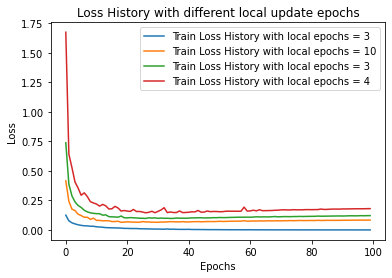

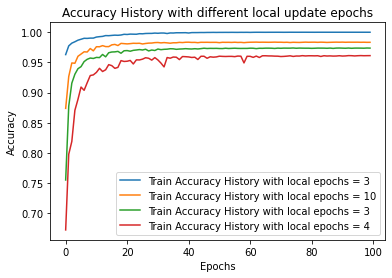

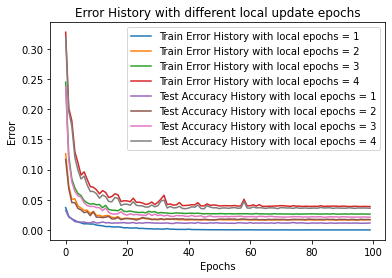

In [83]:
plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
plot_local_update_epochs_list = [3, 10, 3, 4, 5, 10]
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with local epochs = {plot_local_update_epochs_list[i]}")
#for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
#    plt.plot(plot_test_loss_history, label=f"Test Loss History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History with different local update epochs")
plt.legend()
#plt.savefig(f'{current_dataset_name}_loss_history_local_compare_update_epochs_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
plot_local_update_epochs_list = [3, 10, 3, 4, 5, 10]
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
#for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
#    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different local update epochs")
plt.legend()
#plt.savefig(f'{current_dataset_name}_accuracy_history_local_compare_update_epochs_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
plot_local_update_epochs_list = [1, 2, 3, 4, 5, 10]
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with local epochs = {plot_local_update_epochs_list[i]}")
for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
    plt.plot(plot_test_error_history, label=f"Test Accuracy History with local epochs = {plot_local_update_epochs_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error History with different local update epochs")
plt.legend()
#plt.savefig(f'{current_dataset_name}_error_history_local_compare_update_epochs_{train_start_time}.png')
plt.show()

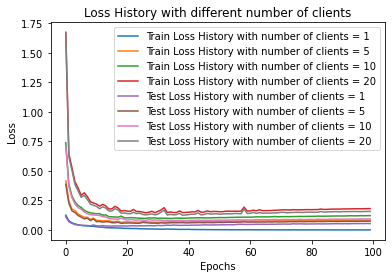

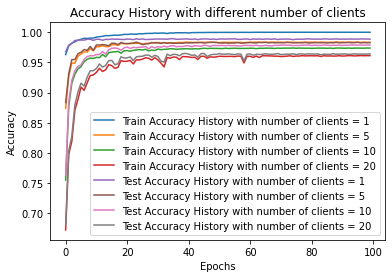

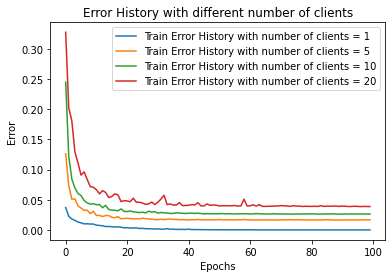

In [86]:
plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
plot_num_clients_list = [1, 5, 10, 20]
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with number of clients = {plot_num_clients_list[i]}")
for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
    plt.plot(plot_test_loss_history, label=f"Test Loss History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History with different number of clients")
plt.legend()
#plt.savefig(f'{current_dataset_name}_loss_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
plot_local_update_epochs_list = [1, 5, 10, 20]
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with number of clients = {plot_num_clients_list[i]}")
for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different number of clients")
plt.legend()
#plt.savefig(f'{current_dataset_name}_accuracy_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
plot_local_update_epochs_list = [1, 5, 10, 20]
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with number of clients = {plot_num_clients_list[i]}")
#for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
#    plt.plot(plot_test_error_history, label=f"Test Accuracy History with number of clients = {plot_num_clients_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error History with different number of clients")
plt.legend()
#plt.savefig(f'{current_dataset_name}_error_history_compare_number_of_clients_{train_start_time}.png')
plt.show()

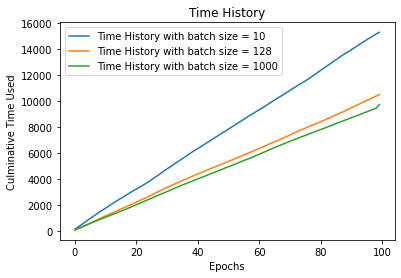

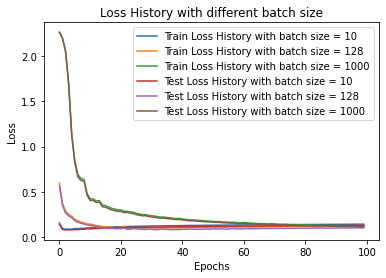

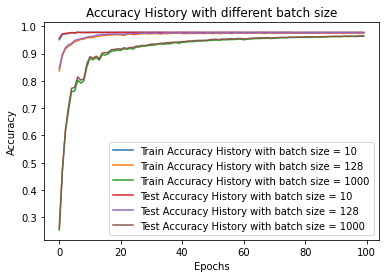

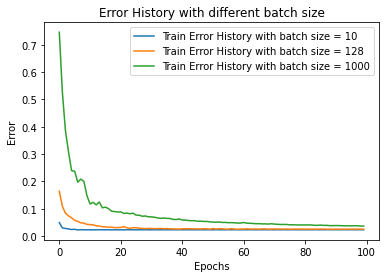

In [11]:
plot_batch_size_list = [10, 128, 1000]

plot_different_time_history = convert_to_list(data_time_history_total)
for i, plot_time_history in enumerate(plot_different_time_history):
    plt.plot(plot_time_history, label=f"Time History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Culminative Time Used")
plt.title("Time History")
plt.legend()
#plt.savefig(f'{current_dataset_name}_time_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_loss_history = convert_to_list(data_train_loss_history_total)
plot_different_local_epoch_test_loss_history = convert_to_list(data_test_loss_history_total)
for i, plot_train_loss_history in enumerate(plot_different_local_epoch_train_loss_history):
    plt.plot(plot_train_loss_history, label=f"Train Loss History with batch size = {plot_batch_size_list[i]}")
for i, plot_test_loss_history in enumerate(plot_different_local_epoch_test_loss_history):
    plt.plot(plot_test_loss_history, label=f"Test Loss History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss History with different batch size")
plt.legend()
#plt.savefig(f'{current_dataset_name}_loss_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_accuracy_history = convert_to_list(data_train_accuracy_history_total)
plot_different_local_epoch_test_accuracy_history = convert_to_list(data_test_accuracy_history_total)
for i, plot_train_accuracy_history in enumerate(plot_different_local_epoch_train_accuracy_history):
    plt.plot(plot_train_accuracy_history, label=f"Train Accuracy History with batch size = {plot_batch_size_list[i]}")
for i, plot_test_accuracy_history in enumerate(plot_different_local_epoch_test_accuracy_history):
    plt.plot(plot_test_accuracy_history, label=f"Test Accuracy History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy History with different batch size")
plt.legend()
#plt.savefig(f'{current_dataset_name}_accuracy_history_compare_batch_size_{train_start_time}.png')
plt.show()

plot_different_local_epoch_train_error_history = convert_to_list(data_train_error_history_total)
plot_different_local_epoch_test_error_history = convert_to_list(data_test_error_history_total)
for i, plot_train_error_history in enumerate(plot_different_local_epoch_train_error_history):
    plt.plot(plot_train_error_history, label=f"Train Error History with batch size = {plot_batch_size_list[i]}")
#for i, plot_test_error_history in enumerate(plot_different_local_epoch_test_error_history):
#    plt.plot(plot_test_error_history, label=f"Test Accuracy History with batch size = {plot_batch_size_list[i]}")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Error History with different batch size")
plt.legend()
#plt.savefig(f'{current_dataset_name}_error_history_compare_batch_size_{train_start_time}.png')
plt.show()

#### Section 3.2 Analysing ####

**Variance Analysis**

We analysis the variance of a particular file.

In [77]:
cost_variance = statistics.variance(data_cost_history)
time_variance = statistics.variance(data_time_history)
train_loss_variance = statistics.variance(data_train_loss_history)
train_accuracy_variance = statistics.variance(data_train_accuracy_history)
train_error_variance = statistics.variance(data_train_error_history)
test_loss_variance = statistics.variance(data_test_loss_history)
test_accuracy_variance = statistics.variance(data_test_accuracy_history)
test_error_variance = statistics.variance(data_test_error_history)
print("=======VARIANCE RESULT=======")
print("Cost Variance: ", cost_variance)
print("Time Variance: ", time_variance)
print("Train Loss Variance: ", train_loss_variance)
print("Train Accuracy Variance: ", train_accuracy_variance)
print("Train Error Variance: ", train_error_variance)
print("Test Loss Variance: ", test_loss_variance)
print("Test Accuracy Variance: ", test_accuracy_variance)
print("Test Error Variance: ", test_error_variance)

=======VARIANCE RESULT=======
Cost Variance:  704818268700.0
Time Variance:  8422183.981836839
Train Loss Variance:  0.000323164804238619
Train Accuracy Variance:  2.9384359946003933e-05
Train Error Variance:  2.938429026573728e-05
Test Loss Variance:  9.712710576974056e-05
Test Accuracy Variance:  5.971414504220187e-06
Test Error Variance:  5.971424979501514e-06


In [62]:
cost_variance_subset = statistics.variance(data_cost_history[:len(data_cost_history) // 2])
time_variance_subset = statistics.variance(data_time_history[:len(data_time_history) // 2])
train_loss_variance_subset = statistics.variance(data_train_loss_history[:len(data_train_loss_history) // 2])
train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[:len(data_train_accuracy_history) // 2])
train_error_variance_subset = statistics.variance(data_train_error_history[:len(data_train_error_history) // 2])
test_loss_variance_subset = statistics.variance(data_test_loss_history[:len(data_test_loss_history) // 2])
test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[:len(data_test_accuracy_history) // 2])
test_error_variance_subset = statistics.variance(data_test_error_history[:len(data_test_error_history) // 2])
print("=======VARIANCE FIRST SUBSET RESULT=======")
print("Cost Variance in Subset: ", cost_variance_subset)
print("Time Variance in Subset: ", time_variance_subset)
print("Train Loss Variance in Subset: ", train_loss_variance_subset)
print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
print("Train Error Variance in Subset: ", train_error_variance_subset)
print("Test Loss Variance in Subset: ", test_loss_variance_subset)
print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
print("Test Error Variance in Subset: ", test_error_variance_subset)

=======VARIANCE FIRST SUBSET RESULT=======
Cost Variance in Subset:  4448729171250.0
Time Variance in Subset:  2239986.527905493
Train Loss Variance in Subset:  0.0033226341989845984
Train Accuracy Variance in Subset:  0.00033200627374483087
Train Error Variance in Subset:  0.0003320064677545357
Test Loss Variance in Subset:  0.0029323502341661693
Test Accuracy Variance in Subset:  0.0002687515103710151
Test Error Variance in Subset:  0.00026875154136920767


In [63]:
cost_variance_subset = statistics.variance(data_cost_history[len(data_cost_history) // 2:])
time_variance_subset = statistics.variance(data_time_history[len(data_time_history) // 2:])
train_loss_variance_subset = statistics.variance(data_train_loss_history[len(data_train_loss_history) // 2:])
train_accuracy_variance_subset = statistics.variance(data_train_accuracy_history[len(data_train_accuracy_history) // 2:])
train_error_variance_subset = statistics.variance(data_train_error_history[len(data_train_error_history) // 2:])
test_loss_variance_subset = statistics.variance(data_test_loss_history[len(data_test_loss_history) // 2:])
test_accuracy_variance_subset = statistics.variance(data_test_accuracy_history[len(data_test_accuracy_history) // 2:])
test_error_variance_subset = statistics.variance(data_test_error_history[len(data_test_error_history) // 2:])
print("=======VARIANCE LAST SUBSET RESULT=======")
print("Cost Variance in Subset: ", cost_variance_subset)
print("Time Variance in Subset: ", time_variance_subset)
print("Train Loss Variance in Subset: ", train_loss_variance_subset)
print("Train Accuracy Variance in Subset: ", train_accuracy_variance_subset)
print("Train Error Variance in Subset: ", train_error_variance_subset)
print("Test Loss Variance in Subset: ", test_loss_variance_subset)
print("Test Accuracy Variance in Subset: ", test_accuracy_variance_subset)
print("Test Error Variance in Subset: ", test_error_variance_subset)

=======VARIANCE LAST SUBSET RESULT=======
Cost Variance in Subset:  4448729171250.0
Time Variance in Subset:  2410085.913468215
Train Loss Variance in Subset:  1.1030179990354924e-05
Train Accuracy Variance in Subset:  3.831619579406546e-08
Train Error Variance in Subset:  3.831910743413425e-08
Test Loss Variance in Subset:  8.528192395099132e-06
Test Accuracy Variance in Subset:  1.2631147232228586e-07
Test Error Variance in Subset:  1.263139043180471e-07
